In [1]:
import os
import pandas as pd

DATA_DIR = '/data/cmpe257-02-fa2019/team-1-meerkats/rsna-intracranial-hemorrhage-detection/'
!ls $DATA_DIR
INPUT_SHAPE = (512, 512, 3)

stage_2_sample_submission.csv  stage_2_test  stage_2_train  stage_2_train.csv


In [2]:
# dcm processing

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    #handle the 12 bit values
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def window_and_scale_brain_subdural_soft(dcm):
    
    #window images
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    #soft_img = window_image(dcm, 40, 380)
    bone_img = window_image(dcm, 600, 2800)
    
    #scale images (0-1)
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img + 20) / 200
    bone_img = (bone_img + 800) / 2800
    
    # combine channels
    return np.array([brain_img, subdural_img, bone_img]).transpose(1,2,0)


def read_trainset(filename=DATA_DIR+"stage_2_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        56346,56347,56348,56349,
        56350,56351,1171830,1171831,
        1171832,1171833,1171834,1171835,
        3705312,3705313,3705314,3705315,
        3705316,3705317,3842478,3842479,
        3842480,3842481,3842482,3842483
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

In [3]:
import keras
import cv2
from math import ceil
import numpy as np
import pydicom

np.random.seed(257)

def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = window_and_scale_brain_subdural_soft(dcm)
        img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
        
    # Some dcms seem to be corrupted
    except ValueError:
        print('Error while parsing {}'.format(path))
        img = np.ones(desired_size)
    
    return img

class DataGenerator(keras.utils.Sequence):

    def __init__(self, img_dir, image_IDs, labels_df, batch_size, img_size, undersample=True):

        self.image_IDs = image_IDs
        self.labels_df = labels_df
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self._undersample = undersample

    def __len__(self):
        return int(ceil(len(self.image_IDs) / self.batch_size))

    def __getitem__(self, index):
        
        batch_ids = self.image_IDs[index*self.batch_size:(index+1)*self.batch_size]
        
        X = np.empty((self.batch_size, *self.img_size))
        Y = np.empty((self.batch_size, 6))
        
        for i, ID in enumerate(batch_ids):
            X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            Y[i,] = self.labels_df.loc[ID].values
        
        return X, Y
    
    def on_epoch_begin(self):
        if self.labels is not None: # for training phase we undersample and shuffle
            # keep probability of any=0 and any=1
            keep_prob = self.labels.iloc[:, 0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_IDs))

Using TensorFlow backend.


In [4]:
from sklearn.model_selection import ShuffleSplit 

train_df = read_trainset()

# k-fold splitting
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=257).split(train_df.index)
# get indeces for one split
train_idx, valid_idx = next(ss)
train_df_kfold = train_df.iloc[train_idx]
valid_df_kfold = train_df.iloc[valid_idx]


traingen = DataGenerator(img_dir=DATA_DIR+'stage_2_train/',
                         image_IDs=train_df_kfold.index[:10000], #MAGIC
                         labels_df=train_df_kfold[:10000], #MAGIC
                         batch_size=16,
                         img_size=INPUT_SHAPE)

validgen = DataGenerator(img_dir=DATA_DIR+'stage_2_train/',
                         image_IDs=valid_df_kfold.index[:1000], #MAGIC
                         labels_df=valid_df_kfold[:1000], #MAGIC
                         batch_size=16,
                         img_size=INPUT_SHAPE)

In [5]:
# custom loss function
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(        1* y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)

# custom performance metric
def correct_diagnoses(y_true, y_pred):
    THRESHOLD = 0.5
    p_thr = K.greater(y_pred, THRESHOLD)
    y_true = K.cast(y_true, dtype='bool')
    
    equals_t = K.equal(p_thr, y_true)
    correct_rows = K.all(equals_t, axis=1)
    correct_rows_int = K.cast(correct_rows, dtype='int32')
    
    return K.sum(correct_rows_int)/K.shape(correct_rows_int)[0]

def correct_positive_diagnoses(y_true, y_pred):
    THRESHOLD = 0.5
    p_thr = K.greater(y_pred, THRESHOLD)
    y_true = K.cast(y_true, dtype='bool')
    
    pos_mask = K.any(y_true, axis=1) #patients with positive diagnoses
    p_thr = p_thr[pos_mask]
    y_true = y_true[pos_mask]
    
    equals_t = K.equal(p_thr, y_true)
    correct_rows = K.all(equals_t, axis=1)
    correct_rows_float = K.cast(correct_rows, dtype='float32')
    
    return K.sum(correct_rows_float)/(K.cast(K.shape(correct_rows_float)[0], dtype='float32')+K.epsilon())

def np_cpd(y_true, pred, thr=0.5): #numpy implementation of correct positive diagnoses
    p_thr = pred > thr

    pos_mask = np.any(y_true, axis=1)

    p_thr = p_thr[pos_mask]
    y_true = y_true[pos_mask]

    p_correct = np.all(p_thr[:len(y_true)] == y_true[:len(p_thr)], axis=1)

    return np.sum(p_correct)/(len(p_thr)+1e-15)

In [6]:
X,y = traingen[0]
import matplotlib.pyplot as plt
plt.imshow(X[2])

In [40]:
import keras
from keras.applications.vgg16 import VGG16
from keras import layers
import numpy as np

conv_base = VGG16(weights=None, input_shape=INPUT_SHAPE ,include_top=False)
conv_base.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5') #doesn't work otherwise without internet access

conv_base.trainable = False
model = keras.models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(6,
#                        activation='sigmoid',
#                        bias_initializer=keras.initializers.Constant(value=-2.0)))
model.add(layers.Dense(6, activation='sigmoid'))
model.name = 'VGG_frozen_base'
model.compile(
    #loss=weighted_log_loss, #custom loss
    loss='binary_crossentropy',
    #loss='categorical_crossentropy', # mutually exclusive
    optimizer=keras.optimizers.Adam(lr=1e-3),
    metrics=[correct_positive_diagnoses])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               33554688  
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 1542      
Total params: 48,270,918
Trainable params: 33,556,230
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
import time
mc = keras.callbacks.ModelCheckpoint(filepath='weights/experiment-epoch={epoch:02d}-valid-loss={val_loss:.2f}.hdf5', monitor='loss', verbose=True, save_best_only=False, save_weights_only=False)
tb = keras.callbacks.TensorBoard(log_dir=f'./Graph-{int(time.time())}', histogram_freq=0, update_freq=6700,
          write_graph=True, write_images=True) 

In [ ]:
hist = model.fit_generator(traingen,
                    validation_data = validgen,
                    epochs=20,
                    verbose=True,
                    use_multiprocessing=True,
                    workers=4,
                    callbacks=[])

Epoch 1/20
625/625 [==============================] - 328s 524ms/step - loss: 0.9295 - correct_positive_diagnoses: 0.0000e+00 - val_loss: 0.7782 - val_correct_positive_diagnoses: 0.0000e+00
Epoch 2/20
605/625 [============================>.] - ETA: 9s - loss: 0.9377 - correct_positive_diagnoses: 0.0000e+00

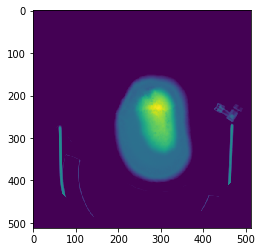

In [33]:
X,y = traingen[0]

plt.imshow(X[0][...,-1])

In [14]:
np.max(p)

0.0

# Conclusion
Not learning. I suspect it to be either:
- problem with the loss function
- perhaps the dense head is out of its capacity?